# SemCor

SemCor is a WordNet annotated subset of the Brown corpus. WordNet has coarse features for nouns and verbs, called "supersenses". These are things like "NOUN.BODY", "VERB.MOTION". Supersenses are coarse semantic features, given by linguists. Once downloaded, NLTK provides easy access to the SemCor corpus, in particular as a stream of tagged chunks. Chunks are coarse constituents.

## Features

In this section, I derive feature representations for words from SemCor. This follows Tsvetkov et al. (2015).

In [1]:
import pandas as pd
from nltk.corpus import semcor
from nltk.corpus.reader.wordnet import Lemma

In [2]:
tagged_chunks = semcor.tagged_chunks(tag='both')
tagged_chunks = list(tagged_chunks) # takes ages

Put the tagged chunks into a `pandas dataframe`. Each row holds a chunk, and I will add columns as I go on.

In [3]:
sc = pd.DataFrame({'chunk': tagged_chunks})

These functions correspond to the columns I want to add.

In [4]:
def extract_words(tc):
    """Return the words of a tagged chunk."""
    words = [w.lower() for w in tc.leaves()]
    return ' '.join(words)

def extract_pos(tc):
    """
    Return the POS of a tagged chunk.
    
    This isn't the cleanest way, but it works for now.
    """
    return tc.pos()[0][1]

def extract_supersense(tc):
    """
    Return the supersense of a tagged chunk, otherwise None.
    
    Only nouns and verbs have supersenses.
    """
    label = tc.label()
    if isinstance(label, Lemma):
        return label.synset().lexname()
    return None

def extract_rough_pos(supersense):
    """Return coarser POS from supersense information."""
    if supersense:
        return supersense.split('.')[0]
    return None

Add the columns.

In [5]:
sc['words'] = sc['chunk'].apply(extract_words)
sc['pos'] = sc['chunk'].apply(extract_pos)
sc['supersense'] = sc['chunk'].apply(extract_supersense)
sc['rough_pos'] = sc['supersense'].apply(extract_rough_pos)

Only nouns and verbs have supersenses in WordNet (adjectives do, but they seem to be ignored in the original paper). We only care about words that have supersenses now. Also, there's a lot of junk words in SemCor. First we replace all digits with '0'. Then we'll drop words that are i) not alphabetic or '0' or ii) multiple words. I can't tell how this is done in the original paper, so I may get slightly different results.

In [6]:
sc = sc[sc['rough_pos'].isin(['noun', 'verb'])]
sc.loc[sc['words'].str.isdigit(), 'words'] = '0'
sc = sc[(sc['words'].str.isalpha()) | (sc['words'].str.match('0'))]

The linguistic features are in fact a distribution over the 41 supersenses.

In [7]:
grouped = sc.groupby('words')
features = grouped['supersense'].value_counts(normalize=True).unstack()
features['count_in_semcor'] = grouped['supersense'].count()
features.reset_index(inplace=True) # make "words" a column not the index
features.fillna(0, inplace=True)
features.columns.name = ''

Now we restrict to words with a certain frequency in the corpus. The original paper has 4199 words when thresholding at a frequency of 5, I get 4847. I believe this discrepancy comes from how words are preprocessed.

In [8]:
threshold = 5
subset = features[features['count_in_semcor'] > threshold]
print('Number of words:', len(subset))

Number of words: 4847


Save my features

In [9]:
subset.to_csv('my_semcor.csv')

## Comparing with reference implementation

I want to know how different my linguistic features are from the original paper's, available [here](https://github.com/ytsvetko/qvec/blob/master/oracles/semcor_noun_verb.supersenses.en). Read in the original paper's. Note that their columns start with "semcor.", which will be helpful when I merge the two sets.

In [14]:
words, dicts = [], []
with open('tsvetkov.txt', 'r') as f:
    for line in f:
        word, _, d = line.partition('\t')
        words.append(word)
        d = eval(d.strip())
        dicts.append(d)

tsvetkov = pd.DataFrame(dicts)
tsvetkov['words'] = words
tsvetkov.fillna(0, inplace=True)

Save Tsvetkov et al.'s features

In [15]:
tsvetkov.to_csv('tsvetkov_semcor.csv')

Merge the two sets. This dataframe has 84 columns: one for the word, one for my count in SemCor, 41 for my features, 41 for their features.

In [16]:
comparison = pd.merge(features, tsvetkov, on=['words'], how='inner')
comparison.head()

,words,noun.Tops,noun.act,noun.animal,noun.artifact,noun.attribute,noun.body,noun.cognition,noun.communication,noun.event,...,semcor.verb.consumption,semcor.verb.contact,semcor.verb.creation,semcor.verb.emotion,semcor.verb.motion,semcor.verb.perception,semcor.verb.possession,semcor.verb.social,semcor.verb.stative,semcor.verb.weather
0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,a,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,abandon,0.0,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.0,0.0
3,ability,0.0,0.0,0.0,0.0,0.727273,0.0,0.272727,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,abolish,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0


So I have two discrete distributions, and I want to know how different/similar they are. I need to ask someone how to do this properly, but I have a few naive ideas.

#### KL divergence

In [17]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Sort the columns so that features in the two lists are in the same position.

In [18]:
their_columns = sorted([c for c in comparison.columns if c.startswith('semcor')])
my_columns = [c.partition('.')[2] for c in their_columns]

def KL(row):
    """
    Helper function for apply KL to a dataframe.
    
    I get errors unless I explicitly convert to float, even though they appear to be floats anyway
    """
    theirs = row[their_columns].values.astype(float)
    mine = row[my_columns].values.astype(float)
    return stats.entropy(theirs, mine)

In [19]:
comparison['KL'] = comparison.apply(KL, axis=1)

`Inf` is not good, meaning that the two distributions are very different. Nearly half of the words have very different distributions.

In [20]:
np.isinf(comparison['KL']).sum() / len(comparison)

0.46724565756823822

Otherwise, most words have similar distributions.

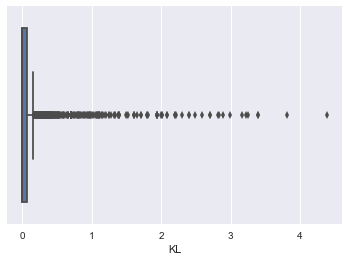

In [21]:
sns.boxplot(comparison[np.isfinite(comparison['KL'])]['KL']);